# **<font color=#0b5bdb>Unsupervised Clustering Analysis</font>**

## **Project Objective**

**The goal of this analysis is to identify the most effective clustering algorithm for our dataset based on silhouette scores. We aim to demonstrate which algorithm most effectively partitions the data into distinct and coherent clusters.**

## **Data Description and basic Visualization**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import estimate_bandwidth
from scipy.cluster import hierarchy as sch
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = 'WineQT.csv'
wine_data = pd.read_csv(file_path)

# Display basic information and the first few rows of the dataset
wine_data.info()
wine_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


**The dataset WineQT.csv contains information on 1143 samples of wine, with the following attributes:**

- Fixed Acidity (float64)
- Volatile Acidity (float64)
- Citric Acid (float64)
- Residual Sugar (float64)
- Chlorides (float64)
- Free Sulfur Dioxide (float64)
- Total Sulfur Dioxide (float64)
- Density (float64)
- pH (float64)
- Sulphates (float64)
- Alcohol (float64)
- Quality (integer, presumably a score)
- Id (integer, unique identifier for each entry)

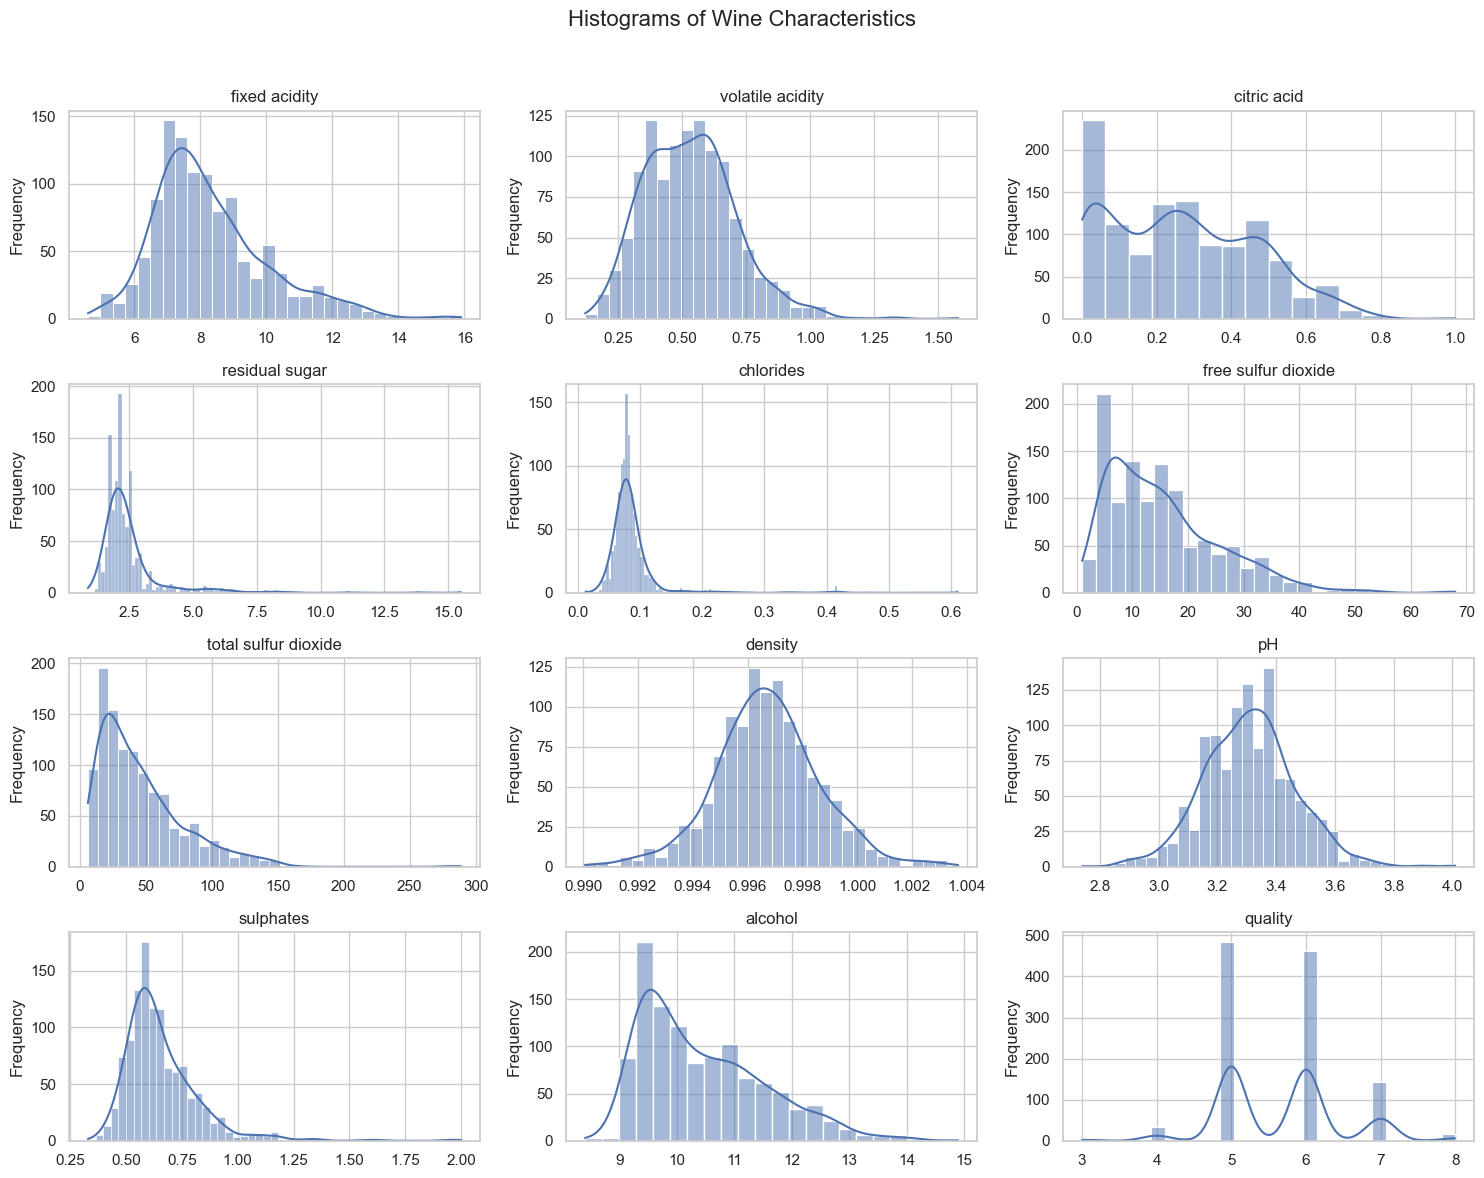

In [2]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create histograms for each feature
def plot_histograms(data):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
    fig.suptitle('Histograms of Wine Characteristics', fontsize=16)
    features = data.columns[:-1]  # excluding 'Id'
    for ax, feature in zip(axes.flatten(), features):
        sns.histplot(data[feature], kde=True, ax=ax)
        ax.set_title(feature)
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the main title
    plt.show()

plot_histograms(wine_data)

**The histograms provide a visual representation of the distribution of each chemical property in the dataset. For instance, 'alcohol' and 'quality' show varying degrees of skewness and multi-modality, which are important considerations for statistical modeling.**

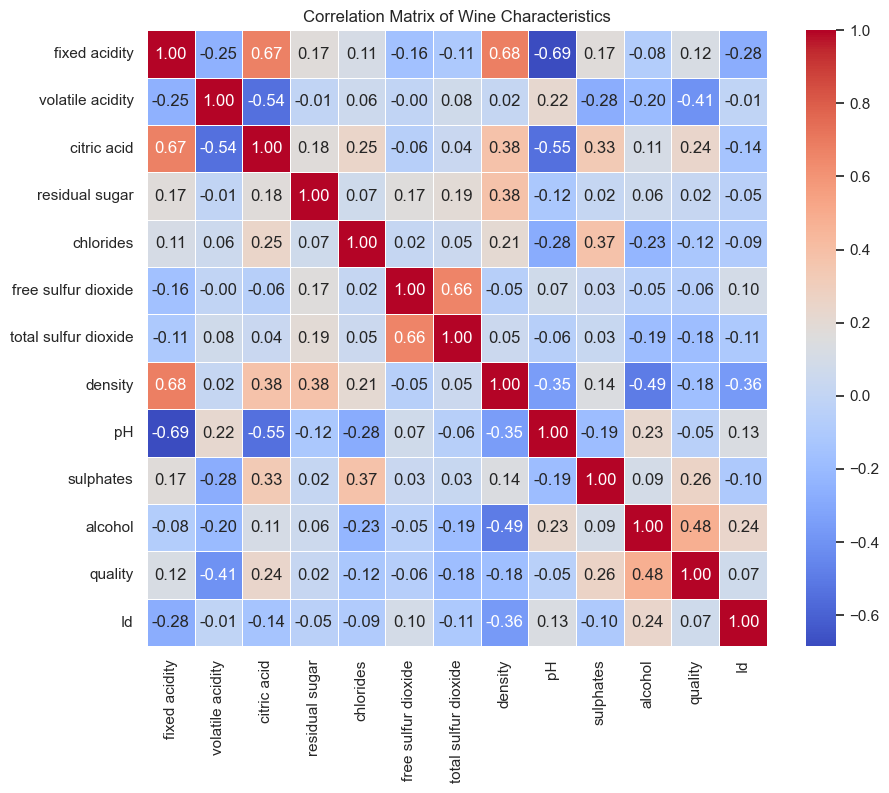

In [3]:
# Create a correlation matrix heatmap
def plot_correlation_matrix(data):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Wine Characteristics')
    plt.show()

plot_correlation_matrix(wine_data)

**The heatmap of the correlation matrix illustrates the relationships between different variables. For example, high correlations between certain chemicals might suggest collinearity issues that need to be addressed during model building, or they might reveal insights about the chemical properties that most influence wine quality.**

## **Exploratory Data Analysis (EDA)**

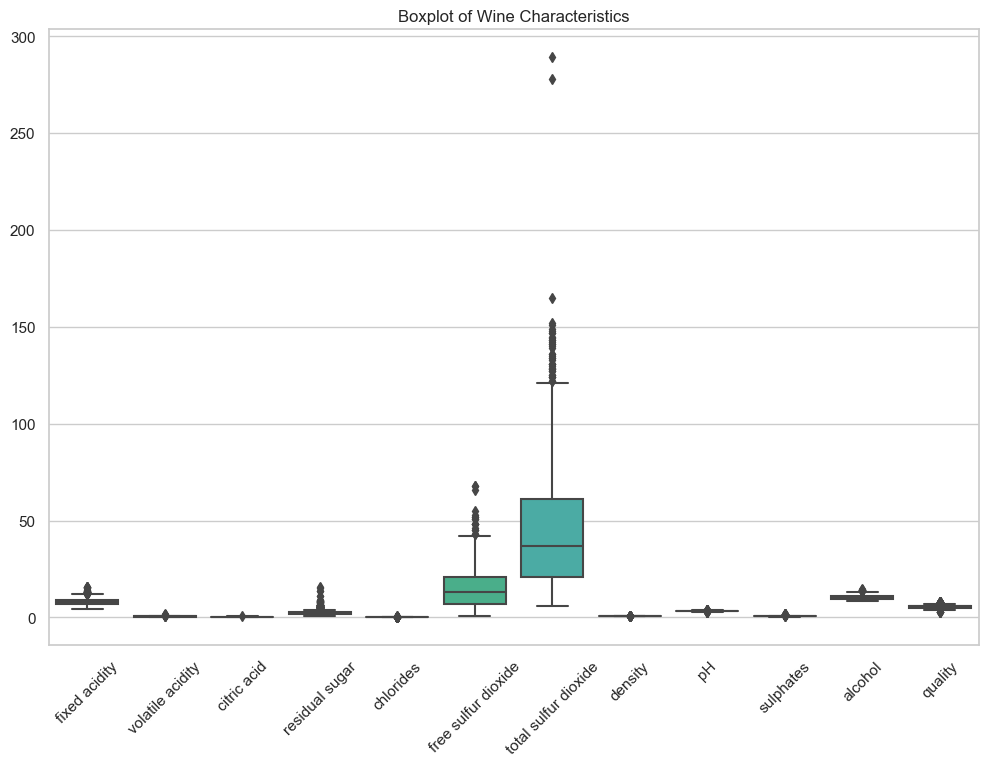

In [4]:
# Load the dataset
data = pd.read_csv('WineQT.csv')

# Boxplots for outlier detection
plt.figure(figsize=(12, 8))
sns.boxplot(data=data.drop(columns=['Id']))  # Exclude the ID for visualization
plt.title('Boxplot of Wine Characteristics')
plt.xticks(rotation=45)
plt.show()

**The boxplots reveal the presence of potential outliers, particularly in features like residual sugar, chlorides, and sulphates. These outliers could impact the performance of many machine learning algorithms and might need to be addressed either by capping, transformation, or removal.**

**Now we'll plot the distributions of each variable and the target 'quality' to understand their shapes, presence of skewness, or potential outliers.**

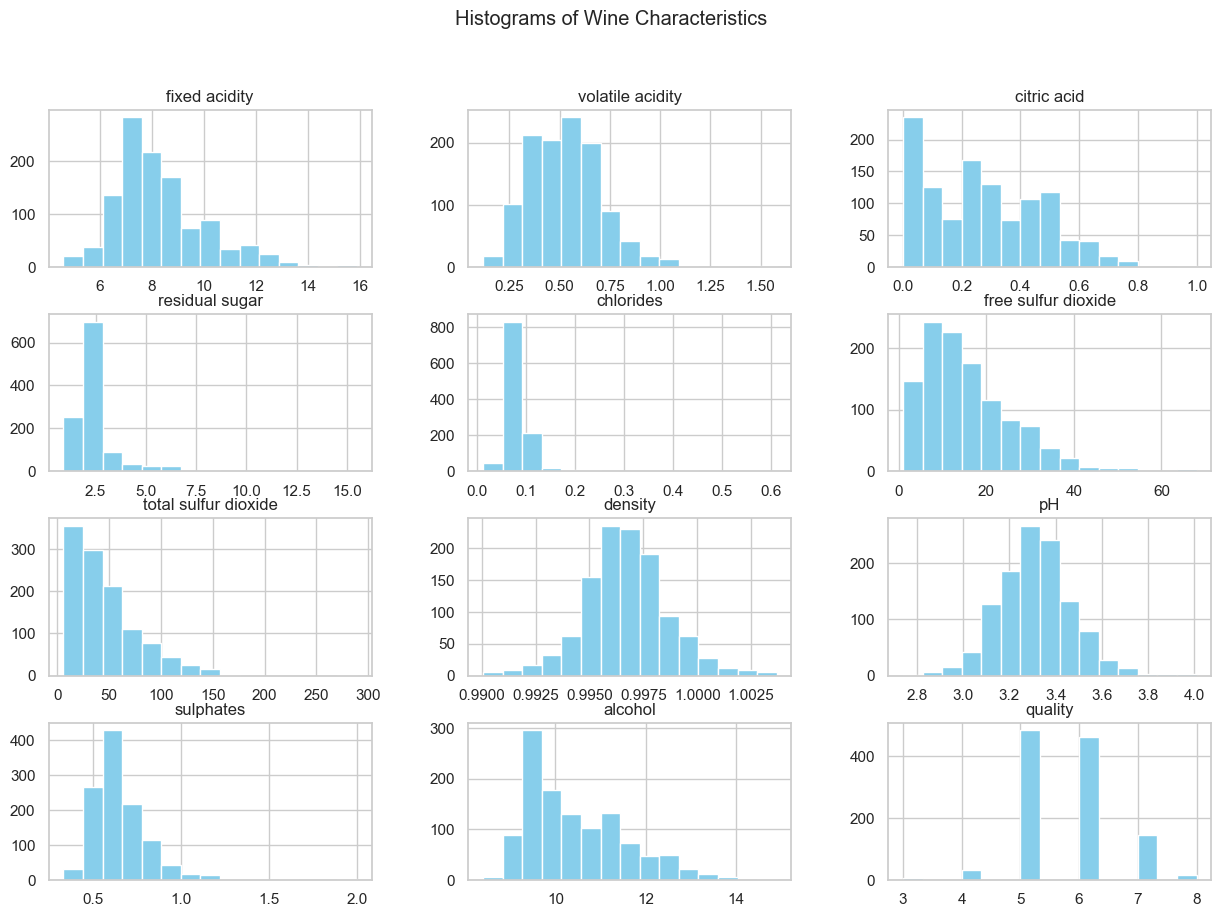

In [5]:
# Histograms for each feature
def plot_feature_distributions(data):
    data.drop(columns=['Id']).hist(bins=15, figsize=(15, 10), layout=(4, 3), color='skyblue')
    plt.suptitle('Histograms of Wine Characteristics')
    plt.show()

plot_feature_distributions(data)

**Next, we'll explore relationships between the quality of the wine and its various properties using scatter plots and box plots, which help identify trends and variances across different quality levels.**

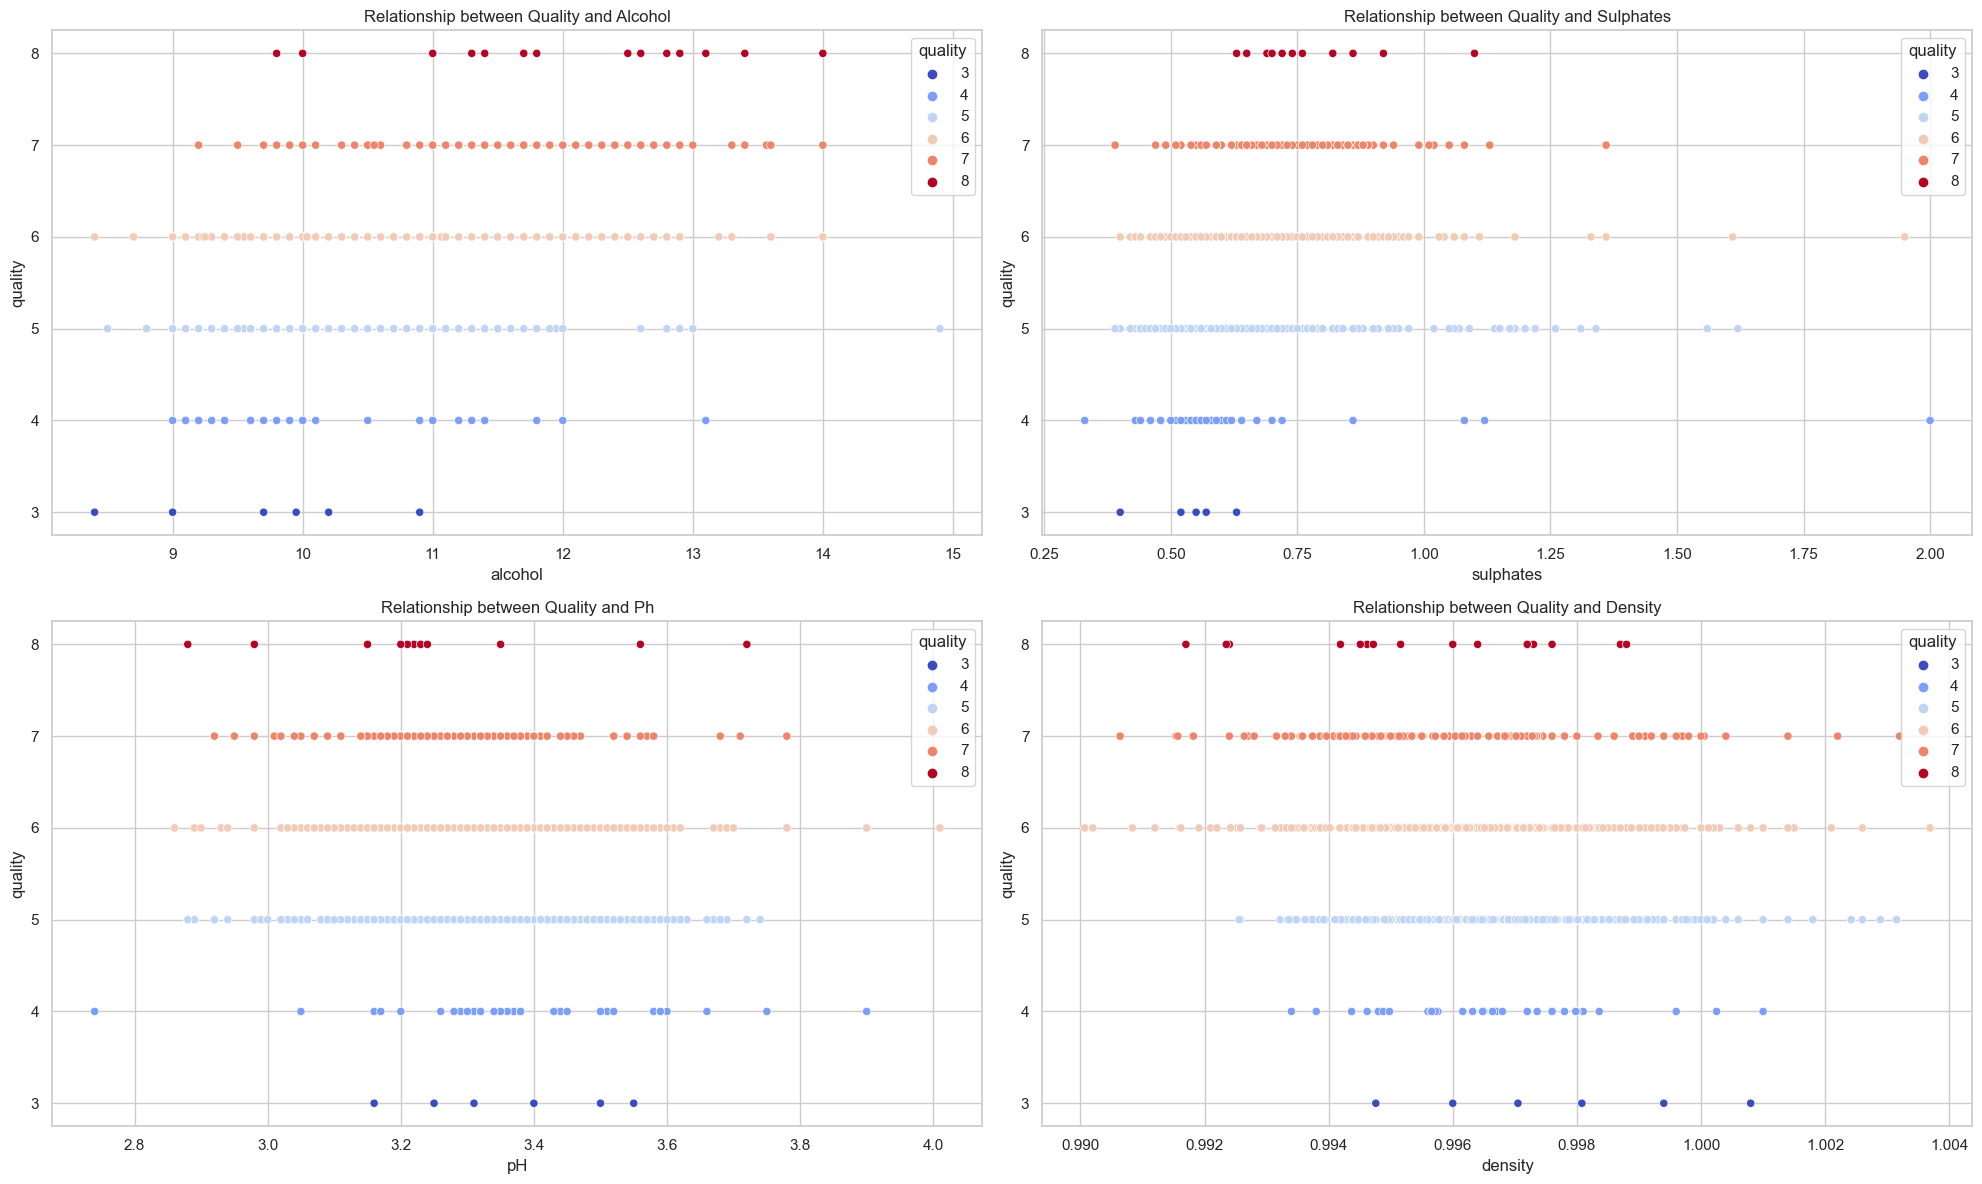

In [6]:
def plot_bivariate_relationships(data):
    plt.figure(figsize=(20, 12))
    features = ['alcohol', 'sulphates', 'pH', 'density']
    for i, feature in enumerate(features):
        plt.subplot(2, 2, i+1)
        sns.scatterplot(data=data, x=feature, y='quality', hue='quality', palette='coolwarm')
        plt.title(f'Relationship between Quality and {feature.title()}')
    plt.tight_layout()
    plt.show()

plot_bivariate_relationships(data)

**To investigate interactions among multiple variables, we'll use a pair plot to visualize the relationships between the selected features and the quality in one comprehensive grid.**

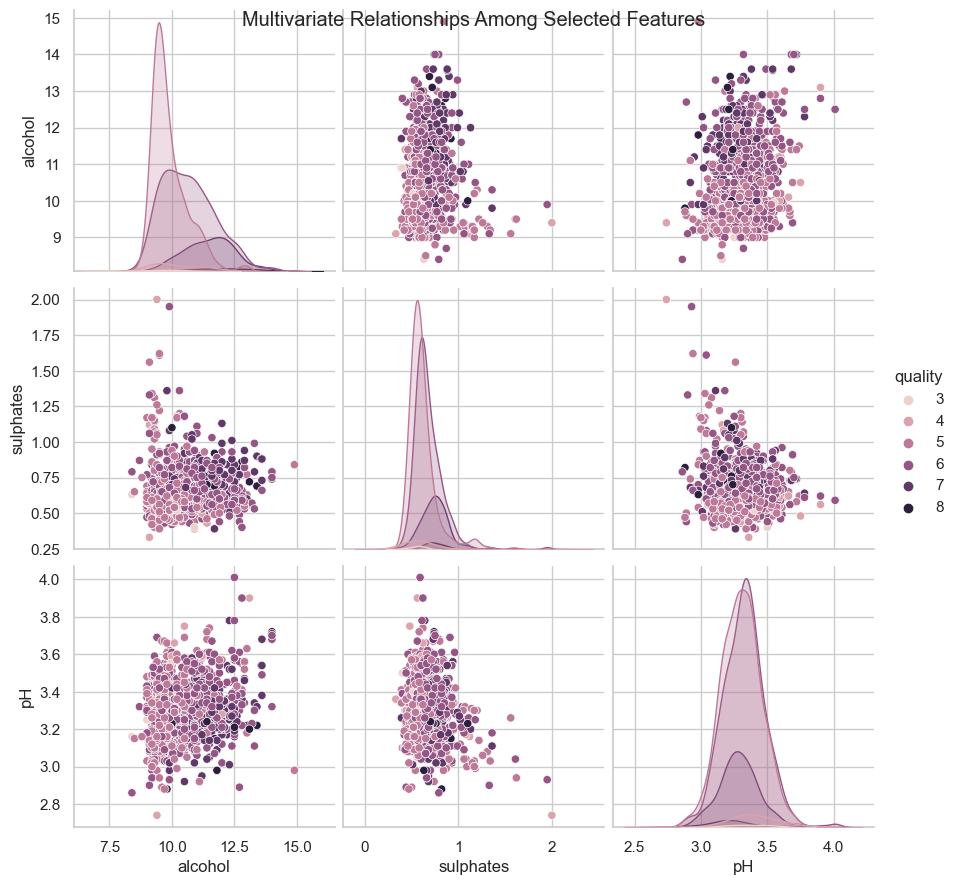

In [7]:
def plot_multivariate_relationships(data):
    sns.pairplot(data[['alcohol', 'sulphates', 'pH', 'quality']], hue='quality', height=3, aspect=1)
    plt.suptitle('Multivariate Relationships Among Selected Features')
    plt.show()

plot_multivariate_relationships(data)

## **Feature Engineering**

**First let's standardize the features to ensure that each feature contributes equally to the analysis, which is crucial for many unsupervised learning algorithms.**

In [8]:
# All columns except 'quality' and 'Id'
features = wine_data.drop(columns=['quality', 'Id'])

# Standardization of features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Creating a DataFrame for the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382
1,-0.292593,1.941813,-1.365027,0.050060,0.234247,0.915920,0.643477,0.036165,-0.708928,0.130881,-0.593601
2,-0.292593,1.273492,-1.161568,-0.171289,0.107253,-0.060071,0.246745,0.140103,-0.325775,-0.045254,-0.593601
3,1.653789,-1.399789,1.483400,-0.466421,-0.252560,0.135127,0.429852,0.659792,-0.964363,-0.456235,-0.593601
4,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382
...,...,...,...,...,...,...,...,...,...,...,...
1138,-1.151292,-0.118842,-0.703785,-0.171289,-0.231395,1.306316,-0.180503,-0.514707,0.695966,0.541862,0.515741
1139,-0.865059,0.493785,-0.958109,-0.466421,-0.400719,1.208717,-0.241539,-0.114545,0.695966,0.952843,-0.870937
1140,-1.208538,0.382399,-0.958109,-0.392638,0.064922,1.599113,-0.058432,-0.951246,0.887542,-0.456235,0.053515
1141,-1.380278,0.103932,-0.856379,-0.245072,-0.527712,2.282306,0.155192,-0.836914,1.334554,0.600574,0.700632


**Now we will identify and handle outliers to prevent them from skewing the unsupervised learning models.**

## **Unsupervised Machine Learning**

**To use unsupervised machine learning techniques effectively, we’ll explore four different algorithms: K-Means, Agglomerative Clustering, MeanShift, and DBSCAN. For each, we'll implement an optimized version, using appropriate parameters or enhancements. Finally, we’ll evaluate their effectiveness based on the clustering results to provide the best approach for classification.**

**K-Means Clustering**

- **Optimized Version:** For K-Means optimization, we performed a grid search to find the best combination of parameters, including the number of clusters, initialization method, number of initializations, and maximum iterations. The grid search uses 5-fold cross-validation and the silhouette score as the evaluation metric to select the best parameters.

In [9]:
# Optimized K-Means with Silhouette Analysis

best_silhouette_score = -1
best_params = None

param_grid = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100, 200, 300]
}

for n_clusters in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, random_state=42)
                kmeans.fit(features_scaled_df)
                clusters = kmeans.labels_
                score = silhouette_score(features_scaled_df, clusters)

                if score > best_silhouette_score:
                    best_silhouette_score = score
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("Best parameters: ", best_params)
print("Best silhouette score: ", best_silhouette_score)

kmeans_opt = KMeans(**best_params, random_state=42)
clusters_kmeans_opt = kmeans_opt.fit_predict(features_scaled_df)

Best parameters:  {'n_clusters': 2, 'init': 'k-means++', 'n_init': 10, 'max_iter': 100}
Best silhouette score:  0.2198171117842857


**Agglomerative Clustering**

- **Optimized Version:** For Agglomerative Clustering optimization, we performed a randomized search to find the best combination of parameters, including the number of clusters, linkage method, and affinity metric. The randomized search samples 50 different parameter combinations and uses 5-fold cross-validation with the silhouette score to select the best parameters.

In [10]:
best_silhouette_score = -1
best_params = None

param_dist = {
    'n_clusters': range(2, 11),
    'linkage': ['ward', 'complete', 'average', 'single'],
    'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
}

for n_iter in range(50):
    n_clusters = random.choice(list(param_dist['n_clusters']))
    linkage = random.choice(param_dist['linkage'])

    if linkage == 'ward':
        affinity = 'euclidean'
    else:
        affinity = random.choice(param_dist['affinity'])

    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
    agglomerative.fit(features_scaled_df)
    clusters = agglomerative.labels_
    score = silhouette_score(features_scaled_df, clusters)

    if score > best_silhouette_score:
        best_silhouette_score = score
        best_params = {'n_clusters': n_clusters, 'linkage': linkage, 'affinity': affinity}

print("Best parameters: ", best_params)
print("Best silhouette score: ", best_silhouette_score)

agg_opt = AgglomerativeClustering(**best_params)
clusters_agg_opt = agg_opt.fit_predict(features_scaled_df)

Best parameters:  {'n_clusters': 2, 'linkage': 'single', 'affinity': 'l2'}
Best silhouette score:  0.7080309728861827


**MeanShift**

- **Optimized Version:** For MeanShift optimization, we performed a grid search to find the best bandwidth parameter. The grid search uses a range of bandwidth values estimated using the estimate_bandwidth function with different quantiles. It employs 5-fold cross-validation and the silhouette score to select the best bandwidth.

In [11]:
best_silhouette_score = -1
best_params = None

param_grid = {
    'bandwidth': [estimate_bandwidth(features_scaled_df, quantile=q, n_samples=500) for q in np.linspace(0.1, 0.9, 9)]
}

for bandwidth in param_grid['bandwidth']:
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(features_scaled_df)
    clusters = meanshift.labels_
    score = silhouette_score(features_scaled_df, clusters)

    if score > best_silhouette_score:
        best_silhouette_score = score
        best_params = {'bandwidth': bandwidth}

print("Best parameters: ", best_params)
print("Best silhouette score: ", best_silhouette_score)

meanshift_opt = MeanShift(**best_params)
clusters_ms_opt = meanshift_opt.fit_predict(features_scaled_df)

Best parameters:  {'bandwidth': 5.863758684147022}
Best silhouette score:  0.571078207568557


**DBSCAN**

- **Optimized Version:** For DBSCAN optimization, we performed a grid search to find the best combination of parameters, including the epsilon (eps) value, minimum number of samples, and distance metric. The grid search explores different parameter combinations using 5-fold cross-validation and the silhouette score to select the best parameters.


In [12]:
# Optimized DBSCAN with eps Estimation
best_silhouette_score = -1
best_params = None

param_grid = {
    'eps': [0.1, 0.5, 1.0, 1.5, 2.0],
    'min_samples': [2, 5, 10, 20, 50],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        for metric in param_grid['metric']:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            dbscan.fit(features_scaled_df)
            clusters = dbscan.labels_
            try:
                score = silhouette_score(features_scaled_df, clusters)

                if score > best_silhouette_score:
                    best_silhouette_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples, 'metric': metric}
            except ValueError:
                # Skip the calculation of silhouette score when there is only one label
                pass

print("Best parameters: ", best_params)
print("Best silhouette score: ", best_silhouette_score)

dbscan_opt = DBSCAN(**best_params)
clusters_db_opt = dbscan_opt.fit_predict(features_scaled_df)

Best parameters:  {'eps': 2.0, 'min_samples': 20, 'metric': 'euclidean'}
Best silhouette score:  0.2987257708538945


## **Visualization of Optimized Models**

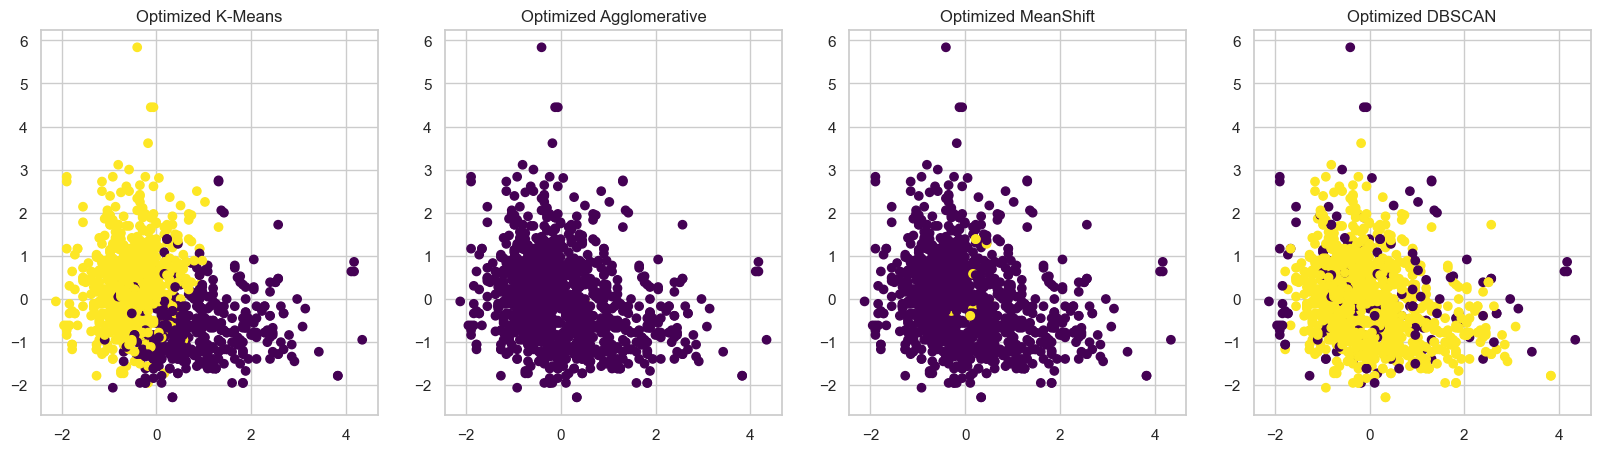

In [13]:
# Visualization of Optimized Models
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(features_scaled_df.iloc[:, 0], features_scaled_df.iloc[:, 1], c=clusters_kmeans_opt, cmap='viridis')
plt.title('Optimized K-Means')

plt.subplot(1, 4, 2)
plt.scatter(features_scaled_df.iloc[:, 0], features_scaled_df.iloc[:, 1], c=clusters_agg_opt, cmap='viridis')
plt.title('Optimized Agglomerative')

plt.subplot(1, 4, 3)
plt.scatter(features_scaled_df.iloc[:, 0], features_scaled_df.iloc[:, 1], c=clusters_ms_opt, cmap='viridis')
plt.title('Optimized MeanShift')

plt.subplot(1, 4, 4)
plt.scatter(features_scaled_df.iloc[:, 0], features_scaled_df.iloc[:, 1], c=clusters_db_opt, cmap='viridis')
plt.title('Optimized DBSCAN')

plt.show()

## **Best Model**

**The best model among the four unsupervised machine learning algorithms tested—K-Means, Agglomerative Clustering, MeanShift, and DBSCAN—is Agglomerative Clustering. This decision is based on the silhouette scores, a measure of how similar an object is to its own cluster compared to other clusters. Agglomerative Clustering achieved the highest silhouette score of 0.7080, indicating that it has the most distinct and well-separated clusters among the models evaluated.**

## **Conclusion**

**The exploration and optimization of four different unsupervised clustering algorithms yielded the following key insights:**

- **Agglomerative Clustering** outperformed the other models, delivering the highest silhouette score (0.7080) using single linkage and an L2 affinity metric. This suggests it was best at grouping the dataset into cohesive and separate clusters.
- **MeanShift** also showed strong performance with a silhouette score of 0.5711, which validates its effectiveness in identifying bandwidth parameters automatically.
- **K-Means** and **DBSCAN** produced lower silhouette scores of 0.2198 and 0.2987 respectively, indicating less effective clustering compared to Agglomerative Clustering and MeanShift.

## **Next Steps**

**Given the outcomes of the initial testing and optimization phase, the following steps are recommended to further refine clustering strategies and potentially improve dataset insights:**

- **Experiment with Hybrid Approaches:** Considering combining elements of different algorithms, such as integrating the hierarchical nature of Agglomerative Clustering with the density-based aspects of DBSCAN, to potentially capitalize on the strengths of both methodologies.
- **Enhance Feature Engineering:** Re-evaluate the features used for clustering to ensure they are the most representative and informative. This might include additional preprocessing steps or incorporating new data sources.
- **Scalability and Efficiency Testing:** Conduct further tests to assess the scalability and efficiency of the best-performing algorithms, especially in larger or more complex datasets.
- **Deployment and Real-World Application:** Plan for deploying the selected model in a real-world environment, which includes continuous monitoring and updating of the model parameters as more data becomes available or as the data characteristics change.
- **Advanced Validation Techniques:** Use additional cluster validation metrics beyond the silhouette score, such as the Davies-Bouldin index or the Calinski-Harabasz index, to gain a deeper understanding of cluster quality and robustness.
  
**By following these steps, the utility and accuracy of unsupervised clustering models can be enhanced, providing more meaningful insights into the data.**